In [101]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [1]:
### 未実施の場合
!pip install lightgbm

In [2]:
### 未実施の場合
!pip install kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle


     |████████████████████████████████| 59 kB 6.9 MB/s  eta 0:00:01
  Created wheel for kaggle: filename=kaggle-1.5.10-py3-none-any.whl size=73268 sha256=6273e90039b698e8027b5f4e6c6fd80a3c8faf2845f47a663654f83ca169d119
  Stored in directory: /home/jupyter/.cache/pip/wheels/ea/c5/fe/7e7fb5b3d1f150fac96188949b3d83d375a4c9df16ba557e52
Successfully built kaggle
  Using cached kaggle-1.5.10-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [3]:
### 未実施の場合
!mkdir .kaggle
!mv kaggle.json .kaggle

In [4]:
### 未実施の場合
!kaggle competitions download -c m5-forecasting-accuracy

 72%|███████████████████████████▍          | 33.0M/45.8M [00:01<00:00, 20.7MB/s]
100%|██████████████████████████████████████| 45.8M/45.8M [00:02<00:00, 23.5MB/s]


In [5]:
!ls

'Untitled Folder'   Untitled.ipynb   m5-forecasting-accuracy.zip   tutorials


In [6]:
### 未実施の場合
!mkdir input
!mkdir output
!mv m5-forecasting-accuracy.zip input/
%cd input
!unzip m5-forecasting-accuracy.zip
%cd ../

/home/jupyter/input
Archive:  m5-forecasting-accuracy.zip
  inflating: calendar.csv            
  inflating: sales_train_evaluation.csv  
  inflating: sales_train_validation.csv  
  inflating: sample_submission.csv   
  inflating: sell_prices.csv         
/home/jupyter


In [102]:
import os
import pandas as pd
import numpy as np
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings('ignore')
from lightgbm import LGBMRegressor
import joblib

In [103]:
sales = pd.read_csv('./input/sales_train_evaluation.csv')
sales.name = 'sales'
calendar = pd.read_csv('./input/calendar.csv')
calendar.name = 'calendar'
prices = pd.read_csv('./input/sell_prices.csv')
prices.name = 'prices'

In [104]:
### はじめに、1~1913が配布された
### つぎに、1914~1941のデータが配布された
### 最後に、1942から1969までを予想する。まずは０を格納する。
for d in range(1942,1970):
    col = 'd_' + str(d)
    sales[col] = 0
    sales[col] = sales[col].astype(np.int16)

In [105]:
sales_bd = np.round(sales.memory_usage().sum()/(1024*1024),1)
calendar_bd = np.round(calendar.memory_usage().sum()/(1024*1024),1)
prices_bd = np.round(prices.memory_usage().sum()/(1024*1024),1)

In [18]:
#Downcast in order to save memory
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

sales = downcast(sales)
prices = downcast(prices)
calendar = downcast(calendar)

In [19]:
sales_ad = np.round(sales.memory_usage().sum()/(1024*1024),1)
calendar_ad = np.round(calendar.memory_usage().sum()/(1024*1024),1)
prices_ad = np.round(prices.memory_usage().sum()/(1024*1024),1)

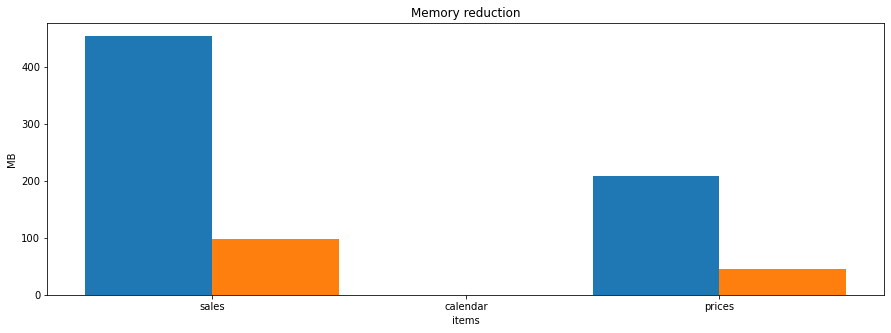

In [20]:
f, ax = plt.subplots(figsize=(15,5))


labels = ["sales", "calendar", "prices"]
height1 = height2 = [sales_bd, calendar_bd, prices_bd]
height2 = [sales_ad, calendar_ad, prices_ad]
x = np.arange(len(height1))
width=0.5
ax.bar(x = x, width=width,height = height1)
ax.bar(x=x+width,width=width,height=height2)
ax.set_xlabel("items")
ax.set_xticks(x+width/2)
ax.set_xticklabels(labels)
ax.set_title("Memory reduction")
ax.set_ylabel("MB")
f.show()

In [21]:
### 元のデータの形
sales.head()
### item_id : アイテム
### dept_id : サブカテゴリ
### cat_id : カテゴリ
### store_id : 店舗
### state_id : 州

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
### データを日付方向に縦列にする

df = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold').dropna()


In [23]:
### 変換後のデータの形
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [152]:
### イベントデータ
calendar.head()
cols_event = [col for col in calendar.columns if ("even" in col) or ("snap" in col)]
print(cols_event)

['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI']


In [25]:
### 価格データ
prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812


In [26]:
### データ結合
df = pd.merge(df, calendar, on='d', how='left')
df = pd.merge(df, prices, on=['store_id','item_id','wm_yr_wk'], how='left') 

In [27]:
### SAVE

df.to_pickle('./output/data1.pkl')
sales.to_pickle('./output/sales.pkl')
calendar.to_pickle('./output/calendar.pkl')
prices.to_pickle('./output/prices.pkl')

In [110]:
### LOAD

df = pd.read_pickle('./output/data1.pkl')
sales = pd.read_pickle('./output/sales.pkl')
calendar = pd.read_pickle('./output/calendar.pkl')
prices = pd.read_pickle('./output/prices.pkl')

In [127]:
### 日付をintに変更
### int16で大丈夫であることを確認
print(np.iinfo(np.int16))

df.loc[:,"d"] = df["d"].apply(lambda x : x.replace("d_","")).astype(np.int16)


Machine parameters for int16
---------------------------------------------------------------
min = -32768
max = 32767
---------------------------------------------------------------



In [111]:
#Introduce lags
lags = [1,2,3,6,12,24,36]
for lag in lags:
    df['sold_lag_'+str(lag)] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['sold'].shift(lag).astype(np.float16)

In [112]:
df['iteam_sold_avg'] = df.groupby('item_id')['sold'].transform('mean').astype(np.float16)
df['state_sold_avg'] = df.groupby('state_id')['sold'].transform('mean').astype(np.float16)
df['store_sold_avg'] = df.groupby('store_id')['sold'].transform('mean').astype(np.float16)
df['cat_sold_avg'] = df.groupby('cat_id')['sold'].transform('mean').astype(np.float16)
df['dept_sold_avg'] = df.groupby('dept_id')['sold'].transform('mean').astype(np.float16)
df['cat_dept_sold_avg'] = df.groupby(['cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)
df['store_item_sold_avg'] = df.groupby(['store_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['cat_item_sold_avg'] = df.groupby(['cat_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['dept_item_sold_avg'] = df.groupby(['dept_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['state_store_sold_avg'] = df.groupby(['state_id','store_id'])['sold'].transform('mean').astype(np.float16)
df['state_store_cat_sold_avg'] = df.groupby(['state_id','store_id','cat_id'])['sold'].transform('mean').astype(np.float16)
df['store_cat_dept_sold_avg'] = df.groupby(['store_id','cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)

In [113]:
df['rolling_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)

In [114]:
df['expanding_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.expanding(2).mean()).astype(np.float16)



In [115]:
df['daily_avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d'])['sold'].transform('mean').astype(np.float16)
df['avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform('mean').astype(np.float16)
df['selling_trend'] = (df['daily_avg_sold'] - df['avg_sold']).astype(np.float16)
df.drop(['daily_avg_sold','avg_sold'],axis=1,inplace=True)



In [116]:
### SAVE

df = df.drop("date",axis=1)

df.to_pickle('./output/data.pkl')
gc.collect();


In [119]:
### LOAD
df = pd.read_pickle('./output/data.pkl')

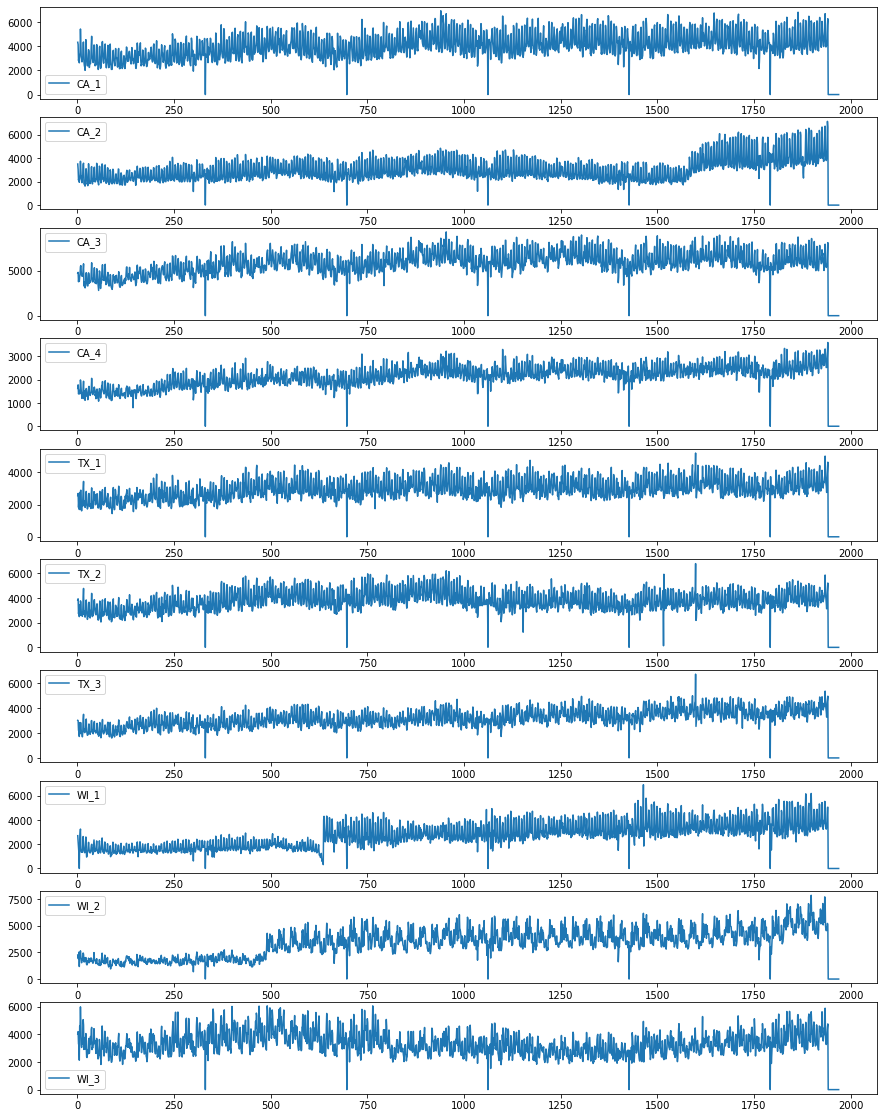

In [141]:
### 店舗ごとのトレンドを確認

df_store_sum = df.groupby(["store_id","d"])["sold"].sum().sort_index().reset_index()

stores = df_store_sum["store_id"].unique()
f,axes = plt.subplots(len(stores),figsize=(15,20))
for i,store in enumerate(stores):
    filter = (df_store_sum["store_id"]==store)
    x = df_store_sum[filter]["d"]
    y = df_store_sum[filter]["sold"]
    axes[i].plot(x,y,label=store)
    axes[i].legend()
f.show()

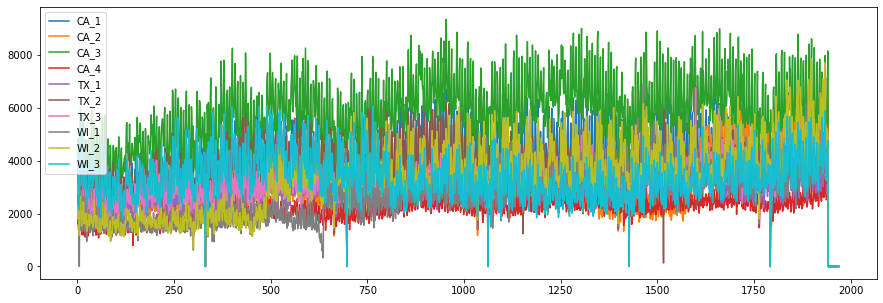

In [142]:
###　店舗ごとのトレンドを確認

df_store_sum = df.groupby(["store_id","d"])["sold"].sum().sort_index().reset_index()

df_store_sum[df_store_sum["store_id"]=="CA_1"].sort_values(by="d")

stores = df_store_sum["store_id"].unique()
f,ax = plt.subplots(figsize=(15,5))
for i,store in enumerate(stores):
    filter = (df_store_sum["store_id"]==store)
    x = df_store_sum[filter]["d"]
    y = df_store_sum[filter]["sold"]
    ax.plot(x,y,label=store)
ax.legend()
f.show()

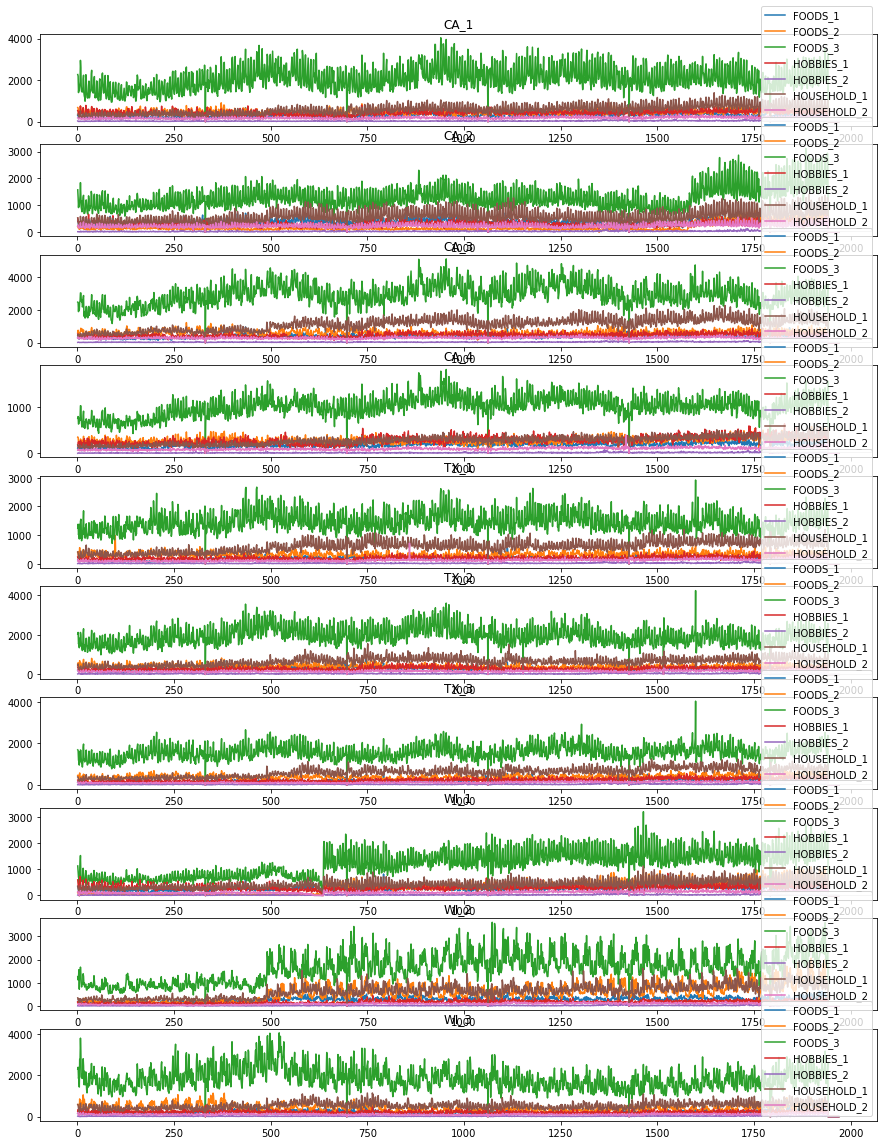

In [143]:
### 店舗ごと、商品カテゴリごとにトレンドを確認

df_store_cat_sum = df.groupby(["store_id","dept_id","d"])["sold"].sum().sort_index().reset_index()

stores = df_store_cat_sum["store_id"].unique()
f,axes = plt.subplots(len(stores),figsize=(15,20))
for i, store in enumerate(stores):
    filter1 = (df_store_cat_sum["store_id"]==store)
    categories = df_store_cat_sum[filter1]["dept_id"].unique()
    for cat in categories:
        filter2 = (df_store_cat_sum[filter1]["dept_id"]==cat)
        x = df_store_cat_sum[filter1&filter2]["d"]
        y = df_store_cat_sum[filter1&filter2]["sold"]
        axes[i].plot(x,y,label=cat)
        axes[i].legend()
    axes[i].set_title(store)

f.show()

item_id : HOBBIES_1_002


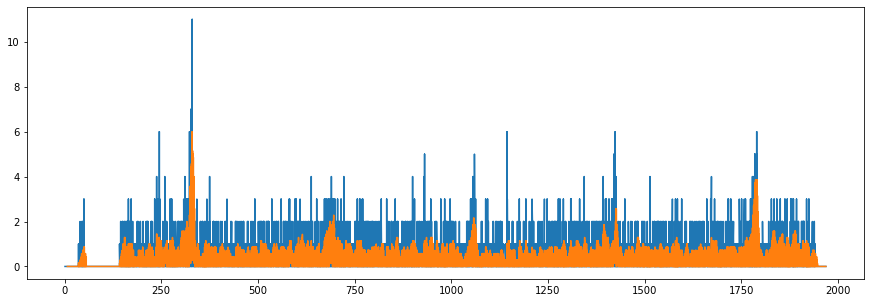

In [149]:
### 商品ごとにトレンドを確認

item_ids = df["item_id"].unique()
item_id = item_ids[1]
print(f"item_id : {item_id}")

f,ax = plt.subplots(figsize=(15,5))

filter1 = (df["item_id"]==item_id)
x = df[filter1]["d"]
y = df[filter1]["sold"]
ax.plot(x,y)
y = df[filter1]["rolling_sold_mean"]
ax.plot(x,y)
f.show()

In [182]:
###　イベントの種類と数を確認
for col_event in cols_event:
    print("-"*40)
    print(col_event)
    print(calendar[col_event].unique())
    print(f"NUll num = {calendar[col_event].isna().sum()}/{len(df['d'].unique())}")

----------------------------------------
event_name_1
[NaN, 'SuperBowl', 'ValentinesDay', 'PresidentsDay', 'LentStart', ..., 'Chanukah End', 'NewYear', 'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter']
Length: 31
Categories (30, object): ['SuperBowl', 'ValentinesDay', 'PresidentsDay', 'LentStart', ..., 'NewYear', 'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter']
NUll num = 1807/1969
----------------------------------------
event_type_1
[NaN, 'Sporting', 'Cultural', 'National', 'Religious']
Categories (4, object): ['Sporting', 'Cultural', 'National', 'Religious']
NUll num = 1807/1969
----------------------------------------
event_name_2
[NaN, 'Easter', 'Cinco De Mayo', 'OrthodoxEaster', 'Father's day']
Categories (4, object): ['Easter', 'Cinco De Mayo', 'OrthodoxEaster', 'Father's day']
NUll num = 1964/1969
----------------------------------------
event_type_2
[NaN, 'Cultural', 'Religious']
Categories (2, object): ['Cultural', 'Religious']
NUll num = 1964/1969
------------------

item_id : HOBBIES_1_002


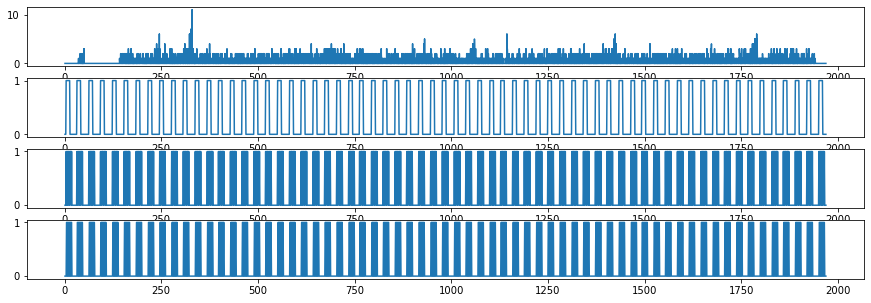

In [192]:
### イベントとの相関を確認

item_index = 1
store_index = 1


item_ids = df["item_id"].unique()
store_ids = df["store_id"].unique()

item_id = item_ids[item_index]
store_id = store_ids[store_index]

print(f"item_id : {item_id}")
print(f"store_id : {store_id}")

f,axes = plt.subplots(4,1,figsize=(15,5))

filter1 = (df["item_id"]==item_id)
filter2 = (df)
x = df[filter1]["d"]
y = df[filter1]["sold"]
axes[0].plot(x,y,label="sold")

for i, col_event in enumerate([col for col in cols_event if "snap" in col]):
    y = df[filter1][col_event]
    axes[i+1].plot(x,y,label=col_event)
ax.legend()
f.show()

In [203]:
calendar_encoded = pd.get_dummies(calendar,columns = ["event_name_1","event_name_2"])

In [204]:
calendar_encoded.shape

(1969, 46)

In [207]:
df[df["item_id"]=="HOBBIES_1_002"].shape

(19690, 43)

In [208]:
df[df["item_id"]=="HOBBIES_1_002"]

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,...,cat_dept_sold_avg,store_item_sold_avg,cat_item_sold_avg,dept_item_sold_avg,state_store_sold_avg,state_store_cat_sold_avg,store_cat_dept_sold_avg,rolling_sold_mean,expanding_sold_mean,selling_trend
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0,11101,Saturday,...,0.695801,0.253906,0.259766,0.259766,1.304688,0.801758,1.020508,NaN,NaN,-0.253906
3050,HOBBIES_1_002_CA_2_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_2,CA,1,0,11101,Saturday,...,0.695801,0.167603,0.259766,0.259766,0.969238,0.584473,0.719727,NaN,NaN,-0.167603
6099,HOBBIES_1_002_CA_3_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_3,CA,1,0,11101,Saturday,...,0.695801,0.230103,0.259766,0.259766,1.892578,0.878906,1.098633,NaN,NaN,-0.230103
9148,HOBBIES_1_002_CA_4_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_4,CA,1,0,11101,Saturday,...,0.695801,0.165527,0.259766,0.259766,0.696777,0.517578,0.674316,NaN,NaN,-0.165527
12197,HOBBIES_1_002_TX_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,TX_1,TX,1,0,11101,Saturday,...,0.695801,0.114258,0.259766,0.259766,0.948242,0.393311,0.479980,NaN,NaN,-0.114258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60019566,HOBBIES_1_002_TX_2_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,TX_2,TX,1969,0,11621,Sunday,...,0.695801,0.153931,0.259766,0.259766,1.220703,0.582520,0.696777,0.0,0.153931,-0.153931
60022615,HOBBIES_1_002_TX_3_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,TX_3,TX,1969,0,11621,Sunday,...,0.695801,0.183350,0.259766,0.259766,1.034180,0.484375,0.573730,0.0,0.183350,-0.183350
60025664,HOBBIES_1_002_WI_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,WI_1,WI,1969,0,11621,Sunday,...,0.695801,0.587891,0.259766,0.259766,0.876465,0.600098,0.755859,0.0,0.587891,-0.587891
60028713,HOBBIES_1_002_WI_2_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,WI_2,WI,1969,0,11621,Sunday,...,0.695801,0.403320,0.259766,0.259766,1.115234,0.340332,0.410156,0.0,0.403320,-0.403320


In [188]:
df.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sold', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'event_name_1',
       'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX',
       'snap_WI', 'sell_price', 'sold_lag_1', 'sold_lag_2', 'sold_lag_3',
       'sold_lag_6', 'sold_lag_12', 'sold_lag_24', 'sold_lag_36',
       'iteam_sold_avg', 'state_sold_avg', 'store_sold_avg', 'cat_sold_avg',
       'dept_sold_avg', 'cat_dept_sold_avg', 'store_item_sold_avg',
       'cat_item_sold_avg', 'dept_item_sold_avg', 'state_store_sold_avg',
       'state_store_cat_sold_avg', 'store_cat_dept_sold_avg',
       'rolling_sold_mean', 'expanding_sold_mean', 'selling_trend'],
      dtype='object')

item_id : HOBBIES_1_002


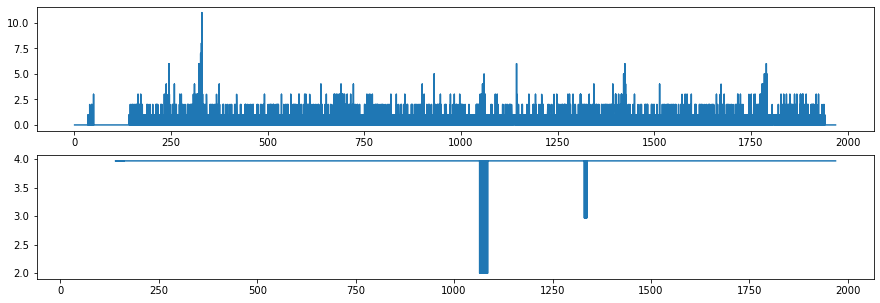

In [191]:
### 価格との相関を確認

item_index = 1


item_ids = df["item_id"].unique()
item_id = item_ids[item_index]
print(f"item_id : {item_id}")

f,axes = plt.subplots(2,1,figsize=(15,5))

filter1 = (df["item_id"]==item_id)
x = df[filter1]["d"]
y = df[filter1]["sold"]
axes[0].plot(x,y,label="sold")
y = df[filter1]["sell_price"]
axes[1].plot(x,y,label="price")
ax.legend()
f.show()


In [33]:
df = df[df['d']>=36]

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58967660 entries, 1067150 to 60034809
Data columns (total 44 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   id                        category      
 1   item_id                   category      
 2   dept_id                   category      
 3   cat_id                    category      
 4   store_id                  category      
 5   state_id                  category      
 6   d                         int16         
 7   sold                      int16         
 8   date                      datetime64[ns]
 9   wm_yr_wk                  int16         
 10  weekday                   category      
 11  wday                      int8          
 12  month                     int8          
 13  year                      int16         
 14  event_name_1              category      
 15  event_type_1              category      
 16  event_name_2              category      
 17  

In [34]:

### データ分割
valid = data[(data['d']>=1914) & (data['d']<1942)][['id','d','sold']]
test = data[data['d']>=1942][['id','d','sold']]
eval_preds = test['sold']
valid_preds = valid['sold']


In [35]:
### カテゴリデータを変換
df = data
d_id = dict(zip(df.id.cat.codes, df.id))
d_item_id = dict(zip(df.item_id.cat.codes, df.item_id))
d_dept_id = dict(zip(df.dept_id.cat.codes, df.dept_id))
d_cat_id = dict(zip(df.cat_id.cat.codes, df.cat_id))
d_store_id = dict(zip(df.store_id.cat.codes, df.store_id))
d_state_id = dict(zip(df.state_id.cat.codes, df.state_id))

cols = df.dtypes.index.tolist()
types = df.dtypes.values.tolist()
cat = df.dtypes.values
for i,type in enumerate(types):
    if type.name == 'category':
        df[cols[i]] = df[cols[i]].cat.codes

data = df

In [36]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,...,cat_dept_sold_avg,store_item_sold_avg,cat_item_sold_avg,dept_item_sold_avg,state_store_sold_avg,state_store_cat_sold_avg,store_cat_dept_sold_avg,rolling_sold_mean,expanding_sold_mean,selling_trend
1067150,14370,1437,3,1,0,0,36,0,11106,2,...,0.695801,0.321533,0.216553,0.216553,1.304688,0.801758,1.020508,0.0,0.0,-0.321533
1067151,14380,1438,3,1,0,0,36,0,11106,2,...,0.695801,0.253906,0.259766,0.259766,1.304688,0.801758,1.020508,0.0,0.0,-0.253906
1067152,14390,1439,3,1,0,0,36,0,11106,2,...,0.695801,0.156982,0.076660,0.076660,1.304688,0.801758,1.020508,0.0,0.0,-0.156982
1067153,14400,1440,3,1,0,0,36,0,11106,2,...,0.695801,1.694336,2.011719,2.011719,1.304688,0.801758,1.020508,0.0,0.0,-1.694336
1067154,14410,1441,3,1,0,0,36,0,11106,2,...,0.695801,0.958984,0.755371,0.755371,1.304688,0.801758,1.020508,0.0,0.0,-0.958984


In [100]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58967660 entries, 1067150 to 60034809
Data columns (total 43 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   id                        int16  
 1   item_id                   int16  
 2   dept_id                   int8   
 3   cat_id                    int8   
 4   store_id                  int8   
 5   state_id                  int8   
 6   d                         int16  
 7   sold                      int16  
 8   wm_yr_wk                  int16  
 9   weekday                   int8   
 10  wday                      int8   
 11  month                     int8   
 12  year                      int16  
 13  event_name_1              int8   
 14  event_type_1              int8   
 15  event_name_2              int8   
 16  event_type_2              int8   
 17  snap_CA                   int8   
 18  snap_TX                   int8   
 19  snap_WI                   int8   
 20  sell_price      

In [38]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,...,cat_dept_sold_avg,store_item_sold_avg,cat_item_sold_avg,dept_item_sold_avg,state_store_sold_avg,state_store_cat_sold_avg,store_cat_dept_sold_avg,rolling_sold_mean,expanding_sold_mean,selling_trend
1067150,14370,1437,3,1,0,0,36,0,11106,2,...,0.695801,0.321533,0.216553,0.216553,1.304688,0.801758,1.020508,0.0,0.0,-0.321533
1067151,14380,1438,3,1,0,0,36,0,11106,2,...,0.695801,0.253906,0.259766,0.259766,1.304688,0.801758,1.020508,0.0,0.0,-0.253906
1067152,14390,1439,3,1,0,0,36,0,11106,2,...,0.695801,0.156982,0.076660,0.076660,1.304688,0.801758,1.020508,0.0,0.0,-0.156982
1067153,14400,1440,3,1,0,0,36,0,11106,2,...,0.695801,1.694336,2.011719,2.011719,1.304688,0.801758,1.020508,0.0,0.0,-1.694336
1067154,14410,1441,3,1,0,0,36,0,11106,2,...,0.695801,0.958984,0.755371,0.755371,1.304688,0.801758,1.020508,0.0,0.0,-0.958984


In [39]:
print(X_train.shape)
print(y_train.shape)

(5726022, 42)
(5726022,)


In [40]:
### テスト
stores = sales.store_id.cat.codes.unique().tolist()
store = stores[0]
df = data[data['store_id']==store]

#Split the data
X_train, y_train = df[df['d']<1914].drop('sold',axis=1), df[df['d']<1914]['sold']
X_valid, y_valid = df[(df['d']>=1914) & (df['d']<1942)].drop('sold',axis=1), df[(df['d']>=1914) & (df['d']<1942)]['sold']
X_test = df[df['d']>=1942].drop('sold',axis=1)

In [41]:
X_train.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,wm_yr_wk,weekday,wday,...,cat_dept_sold_avg,store_item_sold_avg,cat_item_sold_avg,dept_item_sold_avg,state_store_sold_avg,state_store_cat_sold_avg,store_cat_dept_sold_avg,rolling_sold_mean,expanding_sold_mean,selling_trend
1067150,14370,1437,3,1,0,0,36,11106,2,1,...,0.695801,0.321533,0.216553,0.216553,1.304688,0.801758,1.020508,0.0,0.0,-0.321533
1067151,14380,1438,3,1,0,0,36,11106,2,1,...,0.695801,0.253906,0.259766,0.259766,1.304688,0.801758,1.020508,0.0,0.0,-0.253906
1067152,14390,1439,3,1,0,0,36,11106,2,1,...,0.695801,0.156982,0.076660,0.076660,1.304688,0.801758,1.020508,0.0,0.0,-0.156982
1067153,14400,1440,3,1,0,0,36,11106,2,1,...,0.695801,1.694336,2.011719,2.011719,1.304688,0.801758,1.020508,0.0,0.0,-1.694336
1067154,14410,1441,3,1,0,0,36,11106,2,1,...,0.695801,0.958984,0.755371,0.755371,1.304688,0.801758,1.020508,0.0,0.0,-0.958984


In [44]:
X_test.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'event_name_1',
       'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX',
       'snap_WI', 'sell_price', 'sold_lag_1', 'sold_lag_2', 'sold_lag_3',
       'sold_lag_6', 'sold_lag_12', 'sold_lag_24', 'sold_lag_36',
       'iteam_sold_avg', 'state_sold_avg', 'store_sold_avg', 'cat_sold_avg',
       'dept_sold_avg', 'cat_dept_sold_avg', 'store_item_sold_avg',
       'cat_item_sold_avg', 'dept_item_sold_avg', 'state_store_sold_avg',
       'state_store_cat_sold_avg', 'store_cat_dept_sold_avg',
       'rolling_sold_mean', 'expanding_sold_mean', 'selling_trend'],
      dtype='object')

In [56]:
#Get the store ids
stores = sales.store_id.cat.codes.unique().tolist()
for store in stores:
    df = data[data['store_id']==store]
    
    #Split the data
    X_train, y_train = df[df['d']<1914].drop('sold',axis=1), df[df['d']<1914]['sold']
    X_valid, y_valid = df[(df['d']>=1914) & (df['d']<1942)].drop('sold',axis=1), df[(df['d']>=1914) & (df['d']<1942)]['sold']
    X_test = df[df['d']>=1942].drop('sold',axis=1)
    
    #Train and validate
    model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=8,
        num_leaves=50,
        min_child_weight=300
    )
    print('*****Prediction for Store: {}*****'.format(d_store_id[store]))
    model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
             eval_metric='rmse', verbose=20, early_stopping_rounds=20)
    valid_preds[X_valid.index] = model.predict(X_valid)
    eval_preds[X_test.index] = model.predict(X_test)
    filename = './output/model'+str(d_store_id[store])+'.pkl'
    # save model
    joblib.dump(model, filename)
    del model, X_train, y_train, X_valid, y_valid
    gc.collect()


*****Prediction for Store: CA_1*****
Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 0.841371	training's l2: 0.707905	valid_1's rmse: 0.549692	valid_1's l2: 0.302161
[40]	training's rmse: 0.804525	training's l2: 0.647261	valid_1's rmse: 0.5348	valid_1's l2: 0.286011
[60]	training's rmse: 0.783255	training's l2: 0.613489	valid_1's rmse: 0.52753	valid_1's l2: 0.278288
[80]	training's rmse: 0.764822	training's l2: 0.584952	valid_1's rmse: 0.515422	valid_1's l2: 0.26566
[100]	training's rmse: 0.753176	training's l2: 0.567275	valid_1's rmse: 0.509039	valid_1's l2: 0.259121
[120]	training's rmse: 0.742756	training's l2: 0.551686	valid_1's rmse: 0.508121	valid_1's l2: 0.258187
[140]	training's rmse: 0.732605	training's l2: 0.53671	valid_1's rmse: 0.508102	valid_1's l2: 0.258167
Early stopping, best iteration is:
[124]	training's rmse: 0.741067	training's l2: 0.549181	valid_1's rmse: 0.506912	valid_1's l2: 0.256959
*****Prediction for Store: CA_2*****
Trainin

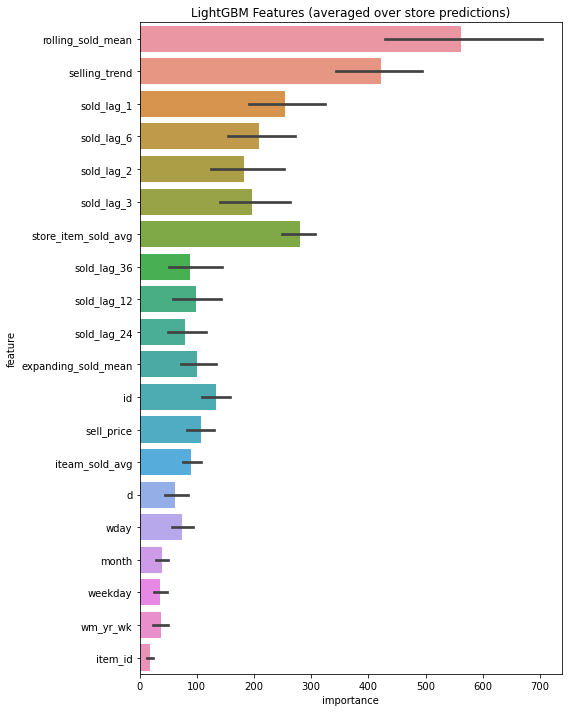

In [63]:
feature_importance_df = pd.DataFrame()
features = [f for f in data.columns if f != 'sold']
for filename in os.listdir('./output/'):
    if 'model' in filename:
        # load model
        model = joblib.load("./output/"+filename)
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        store_importance_df["store"] = filename[5:9]
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (averaged over store predictions)')
    plt.tight_layout()
    
display_importances(feature_importance_df)

In [96]:
#Set actual equal to false if you want to top in the public leaderboard :P
actual = False
if actual == False:
    #Get the validation results(We already have them as less than one month left for competition to end)
    validation = sales[['id']+['d_' + str(i) for i in range(1914,1942)]]
    validation['id']=pd.read_csv('./input/sales_train_validation.csv').id
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
else:
    #Get the actual validation results
    valid['sold'] = valid_preds
    validation = valid[['id','d','sold']]
    validation = pd.pivot(validation, index='id', columns='d', values='sold').reset_index()
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
    validation.id = validation.id.map(d_id).str.replace('evaluation','validation')

#Get the evaluation results
test['sold'] = eval_preds
evaluation = test[['id','d','sold']]
evaluation = pd.pivot(evaluation, index='id', columns='d', values='sold').reset_index()
evaluation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
#Remap the category id to their respective categories
# evaluation.id = evaluation.id.map(d_id)

#Prepare the submission
submit = pd.concat([validation,evaluation]).reset_index(drop=True)
submit.to_csv('./output/submission.csv',index=False)

In [97]:
!kaggle competitions submit m5-forecasting-accuracy -f ./output/submission.csv -m "api submission"

100%|██████████████████████████████████████| 22.8M/22.8M [00:09<00:00, 2.64MB/s]
Successfully submitted to M5 Forecasting - Accuracy